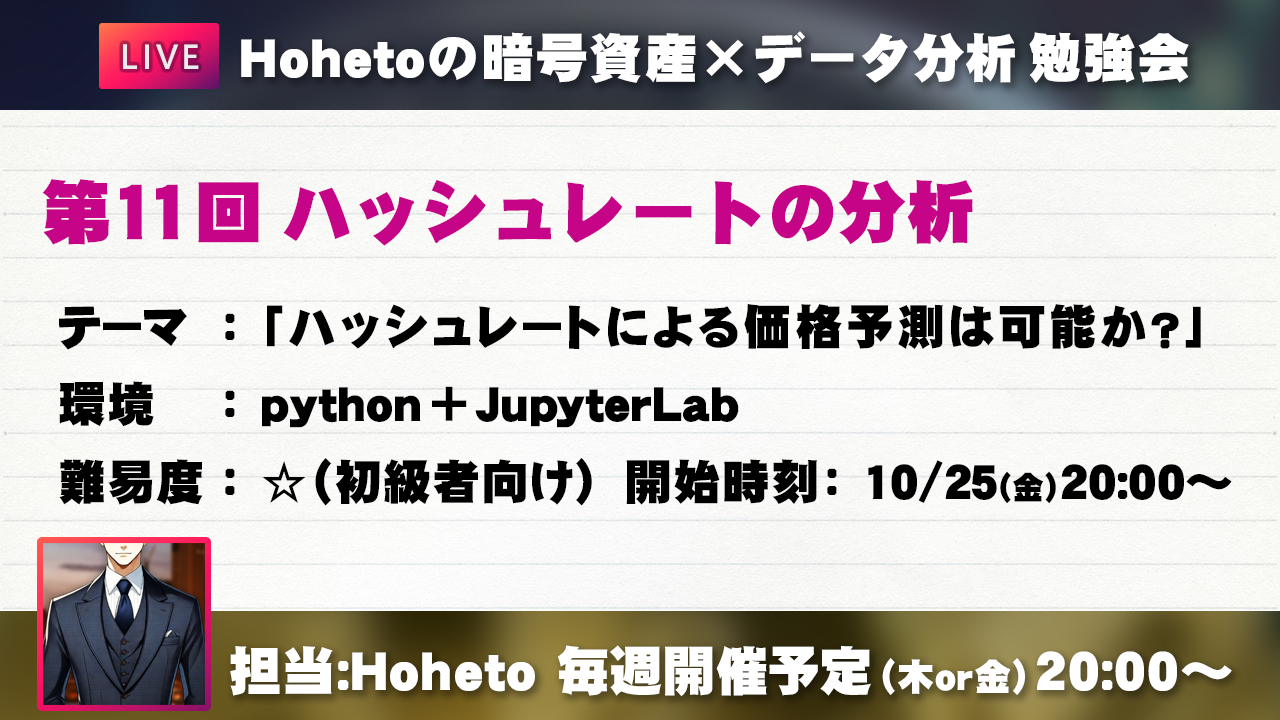

In [1]:
from IPython.display import Image

Image('./images/11_00.png')

# Hoheto勉強会 第11回 ハッシュレートの分析

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- ハッシュレートの変動と価格変化の関係を分析します。
- ハッシュレートを利用した価格予測の可能性について検討します。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆ 1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

plt.rcParams['axes.axisbelow'] = True

In [5]:
import pickle

def dump_pickle(obj, path):
    with open(path, mode="wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

# データ取得

## ハッシュレートの取得

- データ取得先 https://bitcoinvisuals.com/chain-hash-rate
- ご注意！
  - インターネット上からファイルをDLする際は自己責任で、くれぐれも注意してください。
  - 最新のデータを必要としない場合、本分析で使用したデータをgithub上にあげていますのでそちらを利用してください。

In [6]:
hash_rate = pd.read_csv('./data/10_btc_hash_rate.csv')
hash_rate.columns = ['datetime', 'hash_rate']
hash_rate['datetime'] = pd.to_datetime(hash_rate['datetime'], utc=True)
hash_rate['hash_rate'] = hash_rate['hash_rate'] / 1e15
hash_rate = hash_rate.set_index('datetime')

In [7]:
hash_rate

,hash_rate
datetime,
2009-01-03 00:00:00+00:00,4.971027e-11
2009-01-09 00:00:00+00:00,9.444951e-10
2009-01-10 00:00:00+00:00,3.032326e-09
2009-01-11 00:00:00+00:00,4.623055e-09
2009-01-12 00:00:00+00:00,4.672765e-09
...,...
2024-09-24 00:00:00+00:00,6.679757e+05
2024-09-25 00:00:00+00:00,6.633690e+05
2024-09-26 00:00:00+00:00,5.712989e+05


## ビットコインデータの取得(coinbase)

- 価格データ取得用関数。

In [8]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        api = apis[exchange]
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[from_date:to_date]
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関プロット用関数。

In [9]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

- 価格データ取得。

In [10]:
apis = {
    'coinbase': ccxt.coinbase(),
}

In [11]:
btcusd = fetch_ohlcv('coinbase', 'BTC/USD', '2015-08-01', '2024-09-28', '1d')

In [12]:
btcusd

,coinbase_open,coinbase_high,coinbase_low,coinbase_close,coinbase_volume,coinbase_ror
timestamp,,,,,,
2015-08-01 00:00:00+00:00,285.20,285.60,277.26,281.53,3932.449751,-0.012868
2015-08-02 00:00:00+00:00,281.53,282.62,277.33,282.62,3361.086689,0.003872
2015-08-03 00:00:00+00:00,282.62,285.86,280.27,280.95,4741.729107,-0.005909
2015-08-04 00:00:00+00:00,280.95,286.47,280.11,285.51,5580.220530,0.016231
2015-08-05 00:00:00+00:00,285.60,286.25,282.01,282.77,5765.487797,-0.009909
...,...,...,...,...,...,...
2024-09-24 00:00:00+00:00,63338.85,64700.00,62689.15,64272.93,8933.464736,0.014747
2024-09-25 00:00:00+00:00,64272.93,64811.00,62932.80,63130.89,5909.095105,-0.017769
2024-09-26 00:00:00+00:00,63131.13,65865.00,62652.99,65177.21,12789.850355,0.032410


## 結合

- 価格データにハッシュレートのデータを結合します。
  - ちなみにDataFrameはindexが正しく設定されていれば、自動的に対応付けしてくれる。

In [13]:
btcusd['hash_rate'] = hash_rate['hash_rate']

- ハッシュレートの対数差分（≒変化率）を計算。

In [14]:
btcusd['hash_rate_ror'] = np.log(btcusd['hash_rate']).diff()

- nullチェック

In [15]:
btcusd.isnull().sum()

coinbase_open      0
coinbase_high      0
coinbase_low       0
coinbase_close     0
coinbase_volume    0
coinbase_ror       0
hash_rate          0
hash_rate_ror      1
dtype: int64

In [16]:
btcusd = btcusd.dropna()

- 内容チェック

In [17]:
btcusd

,coinbase_open,coinbase_high,coinbase_low,coinbase_close,coinbase_volume,coinbase_ror,hash_rate,hash_rate_ror
timestamp,,,,,,,,
2015-08-02 00:00:00+00:00,281.53,282.62,277.33,282.62,3361.086689,0.003872,392.414063,-0.026145
2015-08-03 00:00:00+00:00,282.62,285.86,280.27,280.95,4741.729107,-0.005909,408.006675,0.038966
2015-08-04 00:00:00+00:00,280.95,286.47,280.11,285.51,5580.220530,0.016231,353.432534,-0.143591
2015-08-05 00:00:00+00:00,285.60,286.25,282.01,282.77,5765.487797,-0.009909,345.636228,-0.022306
2015-08-06 00:00:00+00:00,282.44,282.61,278.95,279.65,5027.855641,-0.009878,371.623914,0.072496
...,...,...,...,...,...,...,...,...
2024-09-24 00:00:00+00:00,63338.85,64700.00,62689.15,64272.93,8933.464736,0.014747,667975.711256,-0.006873
2024-09-25 00:00:00+00:00,64272.93,64811.00,62932.80,63130.89,5909.095105,-0.017769,663368.982213,-0.006920
2024-09-26 00:00:00+00:00,63131.13,65865.00,62652.99,65177.21,12789.850355,0.032410,571298.868180,-0.149419


# 基礎的な分析

- まずはプロットします。

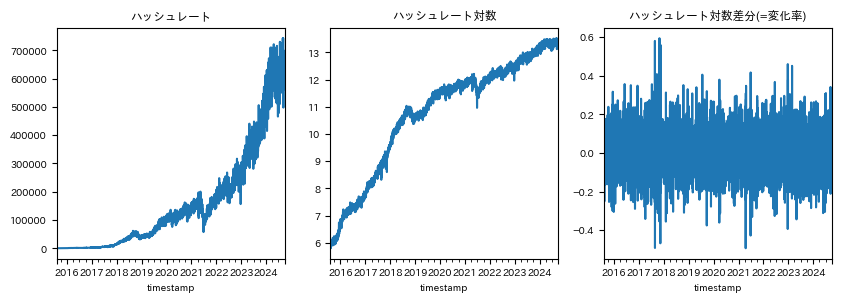

In [18]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('ハッシュレート')
btcusd['hash_rate'].plot();
plt.subplot(1, 3, 2)
plt.title('ハッシュレート対数')
np.log(btcusd['hash_rate']).plot();
plt.subplot(1, 3, 3)
plt.title('ハッシュレート対数差分(=変化率)')
btcusd['hash_rate_ror'].plot();

- ハッシュレートは非定常データ（時期によって平均や分散などの統計的性質が異なる）なので、対数差分系列で分析を進めていきます。

## 自己相関

- 続いて、自己相関を確認します。

件数 3346
棄却域 0.033883877505558824


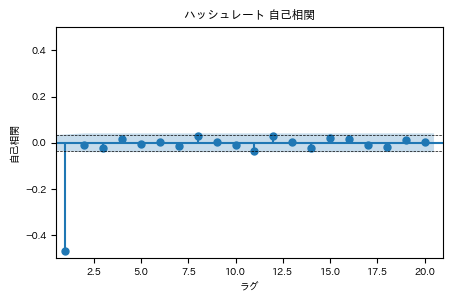

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

hash_rate_ror = btcusd['hash_rate_ror']
threshold = 1.96 / (len(hash_rate_ror)**0.5)
print('件数', len(hash_rate_ror))
print('棄却域', threshold)

plt.figure(figsize=(5, 3))
plot_acf(hash_rate_ror, lags=20, ax=plt.gca(), title='ハッシュレート 自己相関')
plt.xlim(0.5, 21)
plt.ylim(-0.5, 0.5)
plt.axhline(threshold, color='k', linestyle='--', lw=0.5)
plt.axhline(-threshold, color='k', linestyle='--', lw=0.5)
plt.xlabel('ラグ')
plt.ylabel('自己相関');

- 1日前と強めの負の自己相関あり
  - なぜ？
  - だれか教えてください。

## デイリーの価格変化とハッシュレート変化の相関を取る

- それぞれの変化が、もう片方にどのような影響を及ぼしているかを確認します。

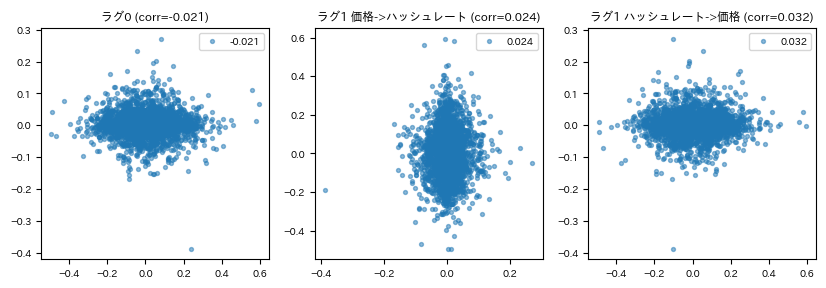

In [20]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(btcusd['hash_rate_ror'], btcusd['coinbase_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(btcusd['coinbase_ror'].shift(1), btcusd['hash_rate_ror'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(btcusd['hash_rate_ror'].shift(1), btcusd['coinbase_ror'], title='ラグ1 ハッシュレート->価格')

- 特に相関なし。
- 一応、長期間のデータなので、時期によって何かの傾向が出ていないか確認します。

### 2023以降

- 特に相関なし。

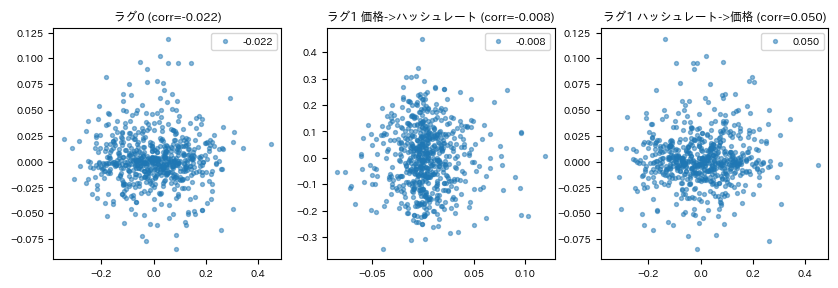

In [21]:
tmp = btcusd['2023':]
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(tmp['hash_rate_ror'], tmp['coinbase_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(tmp['coinbase_ror'].shift(1), tmp['hash_rate_ror'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(tmp['hash_rate_ror'].shift(1), tmp['coinbase_ror'], title='ラグ1 ハッシュレート->価格')

### 2016以前

- 特に相関なし。

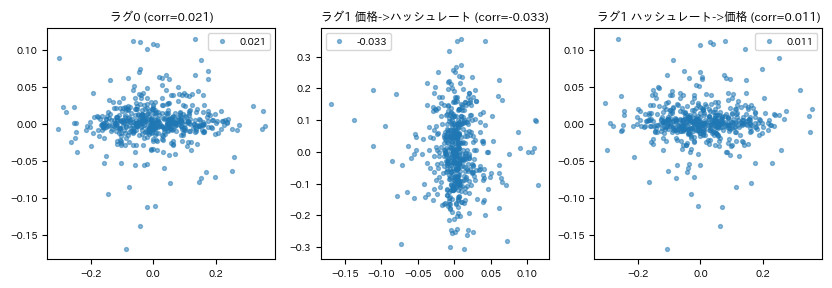

In [22]:
tmp = btcusd[:'2016']
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(tmp['hash_rate_ror'], tmp['coinbase_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(tmp['coinbase_ror'].shift(1), tmp['hash_rate_ror'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(tmp['hash_rate_ror'].shift(1), tmp['coinbase_ror'], title='ラグ1 ハッシュレート->価格')

- さあどうする。

## ここからは直近の1サイクル（2020年以降）に絞って分析を行う。

- 2015～2018あたりの時期と直近とで環境が変わっている可能性があるため。

In [23]:
df = btcusd['2020':]

- 2020年以降でプロット。

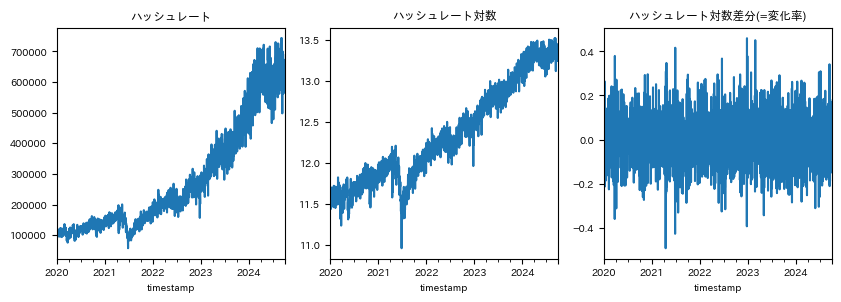

In [24]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('ハッシュレート')
df['hash_rate'].plot();
plt.subplot(1, 3, 2)
plt.title('ハッシュレート対数')
np.log(df['hash_rate']).plot();
plt.subplot(1, 3, 3)
plt.title('ハッシュレート対数差分(=変化率)')
df['hash_rate_ror'].plot();

# 検証1) 前日からの急変後に何が起こるか？

- ハッシュレートが20%以上急落した後のリターンを観察します。

- 1日後・3日後・7日後・14日後の価格リターンを計算します。

In [25]:
tmp = df.copy()
tmp['ror_f1'] = tmp['coinbase_ror'].shift(1)
tmp['ror_f3'] = tmp['coinbase_ror'].rolling(3).sum().shift(-3)
tmp['ror_f7'] = tmp['coinbase_ror'].rolling(7).sum().shift(-7)
tmp['ror_f14'] = tmp['coinbase_ror'].rolling(14).sum().shift(-14)

## 1日後リターン

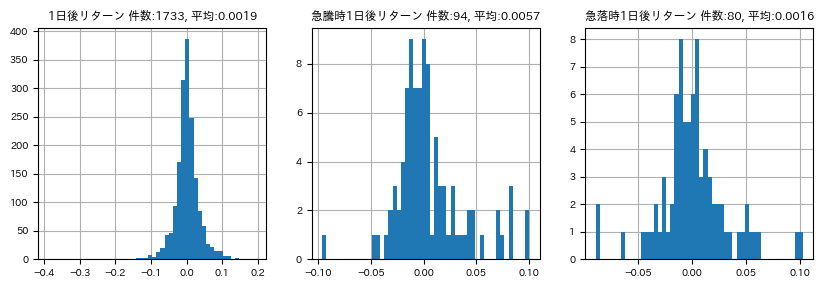

In [26]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
ror_all = tmp['ror_f1'].copy()
ror_up = tmp[tmp['hash_rate_ror'] > 0.2]['ror_f1'].copy()
ror_down = tmp[tmp['hash_rate_ror'] < -0.2]['ror_f1'].copy()

plt.title(f'1日後リターン 件数:{len(ror_all)}, 平均:{ror_all.mean():.4f}')
ror_all.hist(bins=50);

plt.subplot(1, 3, 2)
plt.title(f'急騰時1日後リターン 件数:{len(ror_up)}, 平均:{ror_up.mean():.4f}')
ror_up.hist(bins=50);

plt.subplot(1, 3, 3)
plt.title(f'急落時1日後リターン 件数:{len(ror_down)}, 平均:{ror_down.mean():.4f}')
ror_down.hist(bins=50);

In [27]:
print(f'ハッシュレート急騰後（前日比+20%以上）の1日後リターンの平均: {ror_up.mean():.4f}')
print(f'ハッシュレート急落後（前日比+20%以上）の1日後リターンの平均: {ror_down.mean():.4f}')

ハッシュレート急騰後（前日比+20%以上）の1日後リターンの平均: 0.0057
ハッシュレート急落後（前日比+20%以上）の1日後リターンの平均: 0.0016


In [28]:
from scipy.stats import mannwhitneyu

# MWM検定の実行
u_stat, p_value = mannwhitneyu(ror_up, ror_down, alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 3832.0
p値: 0.8291


- 特に傾向なし。

## 3日後リターン

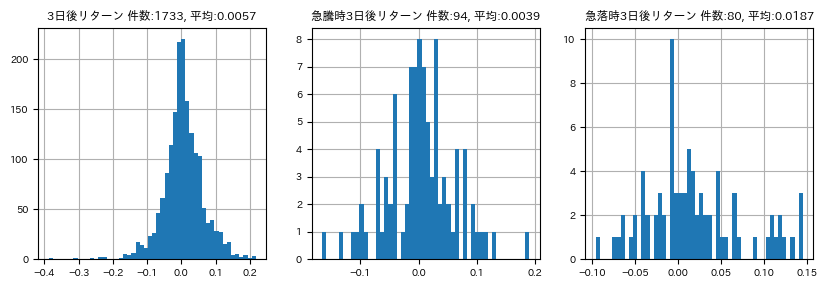

In [29]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
ror_all = tmp['ror_f3'].copy()
ror_up = tmp[tmp['hash_rate_ror'] > 0.2]['ror_f3'].copy()
ror_down = tmp[tmp['hash_rate_ror'] < -0.2]['ror_f3'].copy()

plt.title(f'3日後リターン 件数:{len(ror_all)}, 平均:{ror_all.mean():.4f}')
ror_all.hist(bins=50);

plt.subplot(1, 3, 2)
plt.title(f'急騰時3日後リターン 件数:{len(ror_up)}, 平均:{ror_up.mean():.4f}')
ror_up.hist(bins=50);

plt.subplot(1, 3, 3)
plt.title(f'急落時3日後リターン 件数:{len(ror_down)}, 平均:{ror_down.mean():.4f}')
ror_down.hist(bins=50);

In [30]:
print(f'ハッシュレート急騰後（前日比+20%以上）の3日後リターンの平均: {ror_up.mean():.4f}')
print(f'ハッシュレート急落後（前日比+20%以上）の3日後リターンの平均: {ror_down.mean():.4f}')

ハッシュレート急騰後（前日比+20%以上）の3日後リターンの平均: 0.0039
ハッシュレート急落後（前日比+20%以上）の3日後リターンの平均: 0.0187


In [31]:
u_stat, p_value = mannwhitneyu(ror_up.dropna(), ror_down, alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 3367.0
p値: 0.2359


- 急落後のリターンのほうが平均が大きいように見える。
- しかし有意差なし。

## 7日後リターン

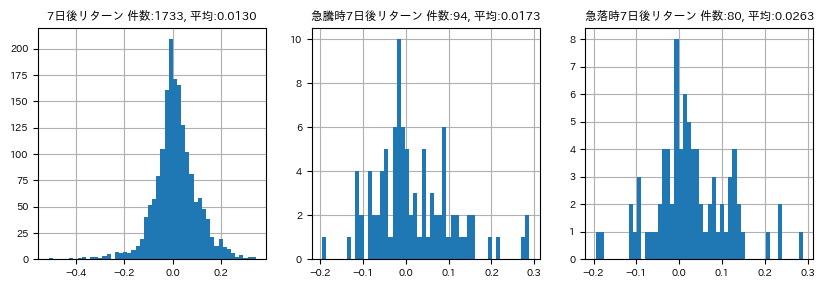

In [32]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
ror_all = tmp['ror_f7'].copy()
ror_up = tmp[tmp['hash_rate_ror'] > 0.2]['ror_f7'].copy()
ror_down = tmp[tmp['hash_rate_ror'] < -0.2]['ror_f7'].copy()

plt.title(f'7日後リターン 件数:{len(ror_all)}, 平均:{ror_all.mean():.4f}')
ror_all.hist(bins=50);

plt.subplot(1, 3, 2)
plt.title(f'急騰時7日後リターン 件数:{len(ror_up)}, 平均:{ror_up.mean():.4f}')
ror_up.hist(bins=50);

plt.subplot(1, 3, 3)
plt.title(f'急落時7日後リターン 件数:{len(ror_down)}, 平均:{ror_down.mean():.4f}')
ror_down.hist(bins=50);

In [33]:
print(f'ハッシュレート急騰後（前日比+20%以上）の7日後リターンの平均: {ror_up.mean():.4f}')
print(f'ハッシュレート急落後（前日比+20%以上）の7日後リターンの平均: {ror_down.mean():.4f}')

ハッシュレート急騰後（前日比+20%以上）の7日後リターンの平均: 0.0173
ハッシュレート急落後（前日比+20%以上）の7日後リターンの平均: 0.0263


In [34]:
u_stat, p_value = mannwhitneyu(ror_up, ror_down, alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 3375.0
p値: 0.2456


- 急落後のリターンのほうが平均が大きいように見える。
- しかし有意差なし。

## 14日後リターン

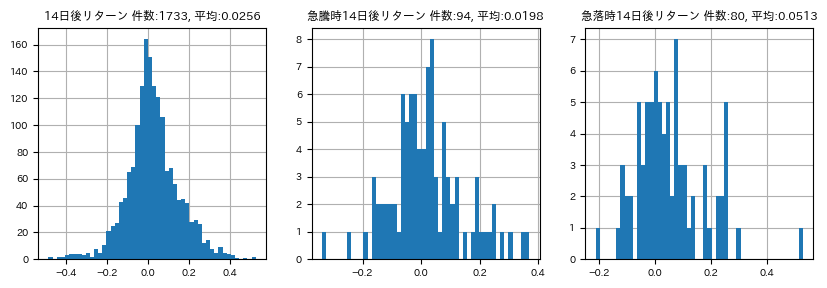

In [35]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
ror_all = tmp['ror_f14'].copy()
ror_up = tmp[tmp['hash_rate_ror'] > 0.2]['ror_f14'].copy()
ror_down = tmp[tmp['hash_rate_ror'] < -0.2]['ror_f14'].copy()

plt.title(f'14日後リターン 件数:{len(ror_all)}, 平均:{ror_all.mean():.4f}')
ror_all.hist(bins=50);

plt.subplot(1, 3, 2)
plt.title(f'急騰時14日後リターン 件数:{len(ror_up)}, 平均:{ror_up.mean():.4f}')
ror_up.hist(bins=50);

plt.subplot(1, 3, 3)
plt.title(f'急落時14日後リターン 件数:{len(ror_down)}, 平均:{ror_down.mean():.4f}')
ror_down.hist(bins=50);

In [36]:
print(f'ハッシュレート急騰後（前日比+20%以上）の14日後リターンの平均: {ror_up.mean():.4f}')
print(f'ハッシュレート急落後（前日比+20%以上）の14日後リターンの平均: {ror_down.mean():.4f}')

ハッシュレート急騰後（前日比+20%以上）の14日後リターンの平均: 0.0198
ハッシュレート急落後（前日比+20%以上）の14日後リターンの平均: 0.0513


In [37]:
u_stat, p_value = mannwhitneyu(ror_up, ror_down, alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 3226.0
p値: 0.1072


- 急落後のリターンのほうが平均が明らかに大きいように見える。
- しかしこれも有意差なし。

## 参考 ハッシュレート急落時（1日で-20%）にBTCロング

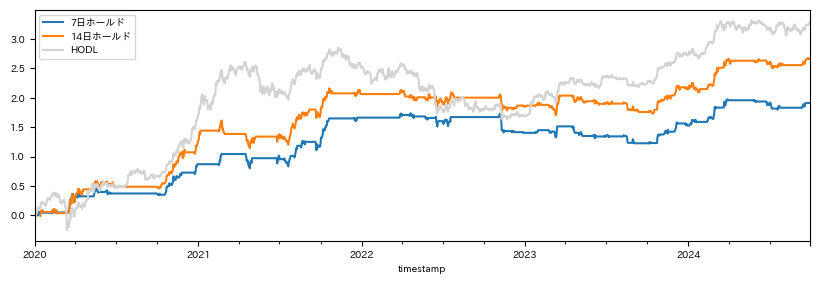

In [38]:
tmp['signal'] = 0
tmp.loc[tmp['hash_rate_ror'] < -0.2, 'signal'] = 1
tmp['signal7'] = tmp['signal'].rolling(7).max()
tmp['signal14'] = tmp['signal'].rolling(14).max()

plt.figure(figsize=(10, 3))
(tmp['signal7'] * tmp['ror_f1']).cumsum().plot(label='7日ホールド')
(tmp['signal14'] * tmp['ror_f1']).cumsum().plot(label='14日ホールド')
tmp['ror_f1'].cumsum().plot(label='HODL', color='lightgray')
plt.legend();

- まずまずか？

# 検証2) 週単位でのハッシュレートの変化の後に何が起こるか？

- 週足での価格リターンとハッシュレート変化を計算します。

In [39]:
df_1w = df.resample('1w').agg({'coinbase_ror': 'sum', 'coinbase_volume': 'sum', 'hash_rate_ror': 'sum'})

- 相関をプロットします。

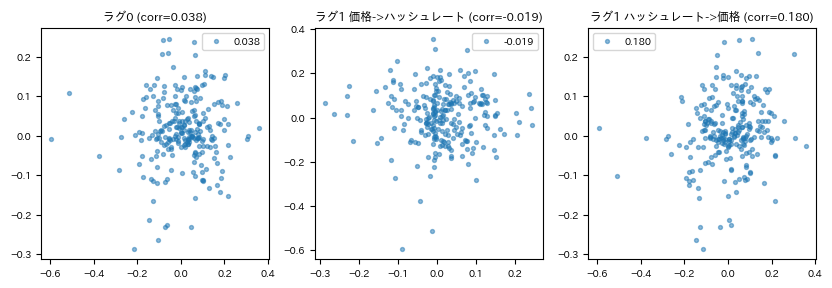

In [40]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df_1w['hash_rate_ror'], df_1w['coinbase_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(df_1w['coinbase_ror'].shift(1), df_1w['hash_rate_ror'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(df_1w['hash_rate_ror'].shift(1), df_1w['coinbase_ror'], title='ラグ1 ハッシュレート->価格')

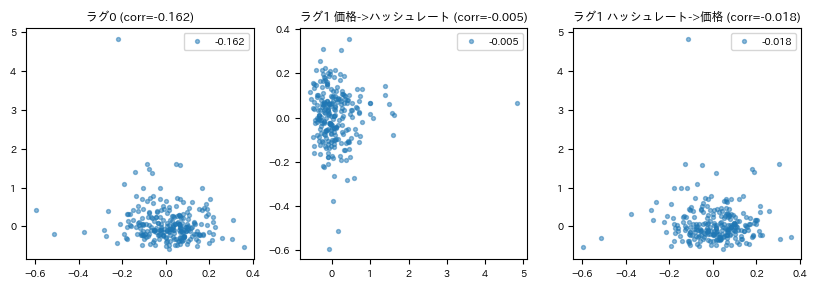

In [41]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
df_1w['volume_ror'] = df_1w['coinbase_volume'].pct_change()
plot_corr(df_1w['hash_rate_ror'], df_1w['volume_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(df_1w['volume_ror'].shift(1), df_1w['hash_rate_ror'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(df_1w['hash_rate_ror'].shift(1), df_1w['volume_ror'], title='ラグ1 ハッシュレート->価格')

- 週足でのハッシュレート変化→価格に若干の相関が見られる？

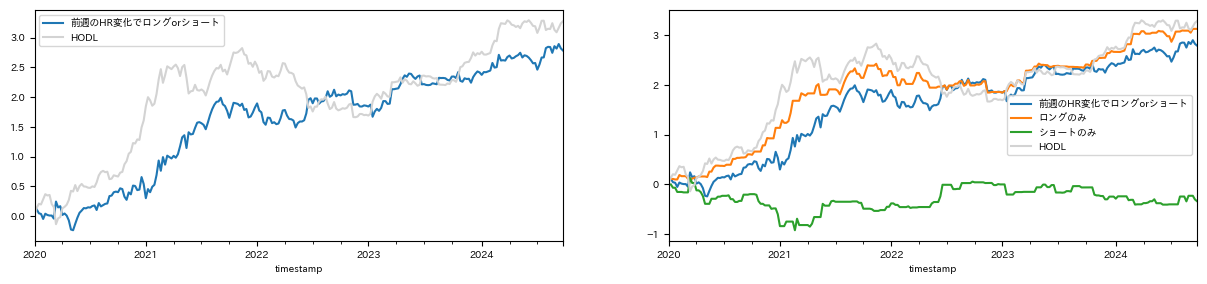

In [42]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
df_1w['signal'] = np.sign(df_1w['hash_rate_ror'].shift(1))
(df_1w['signal'] * df_1w['coinbase_ror']).cumsum().plot(label='前週のHR変化でロングorショート')
df_1w['coinbase_ror'].cumsum().plot(label='HODL', color='lightgray')
plt.legend();
plt.subplot(1, 2, 2)
df_1w['signal'] = np.sign(df_1w['hash_rate_ror'].shift(1))
(df_1w['signal'] * df_1w['coinbase_ror']).cumsum().plot(label='前週のHR変化でロングorショート')
(df_1w['signal'].replace(-1, 0) * df_1w['coinbase_ror']).cumsum().plot(label='ロングのみ')
(df_1w['signal'].replace(1, 0) * df_1w['coinbase_ror']).cumsum().plot(label='ショートのみ')
df_1w['coinbase_ror'].cumsum().plot(label='HODL', color='lightgray')
plt.legend();

- 損益曲線を確認するとパッと見有効なようにも見えるが、
- 稼いでいるのはロングだけ。
- 微妙。

# 検証3) ハッシュリボンの分析

- ハッシュリボンが有効かどうかを、損益曲線で確認してみる。

- https://nextmoney.jp/?p=31591
- Charles Edwards（チャールズ・エドワード）氏によると、ハッシュリボン（60日移動平均線と30日移動平均線）のみで最初はハッシュリボンを提唱していましたが、現時点では正式なハッシュリボンを以下の内容としています。
- 1）ハッシュレートの30日移動平均線と60日移動平均線をプロット
- 2）30日移動平均線が60日移動平均線を上回ったら緑のシグナルが点灯
- 3）ビットコイン価格の10日移動平均線、20日移動平均線をプロット
- 4）2）の状態かつ、BTC価格の10日移動平均線が20日移動平均線を上回ったらハッシュレート移動平均線の部分に青の買いシグナルが点灯

In [43]:
tmp = btcusd['2020':].copy()
tmp['hash_rate_sma30'] = tmp['hash_rate'].rolling(30).mean()
tmp['hash_rate_sma60'] = tmp['hash_rate'].rolling(60).mean()
tmp['price_sma10'] = tmp['coinbase_open'].rolling(10).mean()
tmp['price_sma20'] = tmp['coinbase_open'].rolling(20).mean()

tmp['hash_rate_signal'] = 0

condition1 = tmp['hash_rate_sma30'] > tmp['hash_rate_sma60']  # 条件1: ハッシュレートの30日MAが60日MAを上回る（ゴールデンクロス）
condition2 = tmp['price_sma10'] > tmp['price_sma20']          # 条件2: BTC価格の10日MAが20日MAを上回る
condition1_prev = condition1.shift(1, fill_value=False)
condition2_prev = condition2.shift(1, fill_value=False)
condition1_cross = condition1 & ~condition1_prev    # 条件1の交差点を検出（ゴールデンクロス）
condition2_cross = condition2 & ~condition2_prev    # 条件2の交差点を検出（BTC価格のゴールデンクロス）

tmp.loc[condition1_cross, 'hash_rate_signal'] = 1               # シグナル1: 条件1がTrueに変化したときに1（緑のシグナル）
tmp.loc[condition1 & condition2_cross, 'hash_rate_signal'] = 2  # シグナル2: 条件1がTrueの状態で、条件2がTrueに変化したときに2（青の買いシグナル）

In [44]:
buy_signal_list = []
green = False
for hashrate_signal in tmp['hash_rate_signal'].values:
    buy_signal = 0
    if hashrate_signal == 1:
        # もしもグリーンが点灯したら
        green = True
    elif hashrate_signal == 2:
        # もしもグリーンが点灯中に青が点灯したら、買いシグナルを出してグリーンをリセット
        if green:
            buy_signal = 1
            green = False
    buy_signal_list.append(buy_signal)

tmp['buy_signal'] = buy_signal_list

- 緑矢印が、ハッシュリボンのゴールデンクロスの場所。
- 青矢印が、価格のゴールデンクロスの場所。
- 赤矢印が青矢印に重なっているところが、緑シグナルが点灯後に最初に青シグナルが点灯した場所 = 買いシグナル。

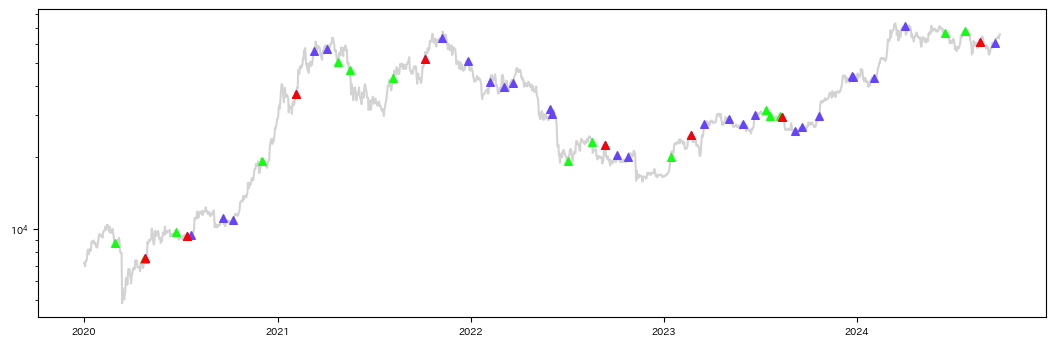

In [45]:
plt.figure(figsize=(13, 4))
plt.plot(tmp['coinbase_open'], color='lightgray')
plt.scatter(tmp[tmp['hash_rate_signal'] == 1].index, tmp[tmp['hash_rate_signal'] == 1]['coinbase_open'], marker='^', s=30, color='#11FF11', zorder=2)
plt.scatter(tmp[tmp['hash_rate_signal'] == 2].index, tmp[tmp['hash_rate_signal'] == 2]['coinbase_open'], marker='^', s=30, color='#6644FF', zorder=2)
plt.scatter(tmp[tmp['buy_signal'] == 1].index, tmp[tmp['buy_signal'] == 1]['coinbase_open'], marker='^', s=30, color='red', zorder=2)
plt.yscale('log');

In [46]:
tmp['ror_f30'] = tmp['coinbase_ror'].rolling(30).sum().shift(-30)
tmp['ror_f60'] = tmp['coinbase_ror'].rolling(60).sum().shift(-60)

- 買いシグナルが出たとき、30日ホールド（8回中6回プラス）

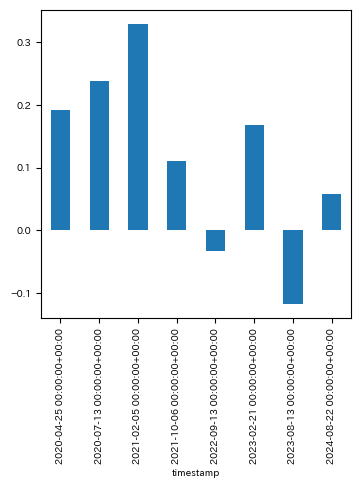

In [47]:
tmp[tmp['buy_signal'] == 1]['ror_f30'].plot(kind='bar');

- 買いシグナルが出たとき、60日ホールド（8回中5回プラス）

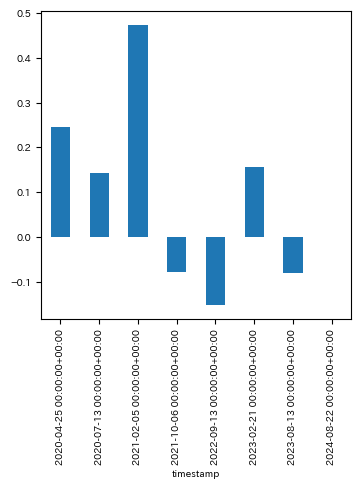

In [48]:
tmp[tmp['buy_signal'] == 1]['ror_f60'].plot(kind='bar');

- 損益曲線を確認する。
  - 買いシグナルが出たタイミングで30日分のリターン、あるいは60日分のリターンを集計していく。

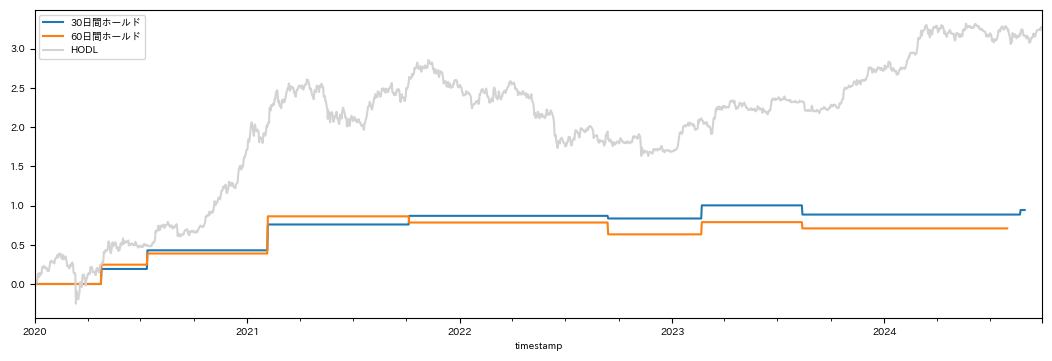

In [49]:
plt.figure(figsize=(13, 4))
(tmp['ror_f30'] * tmp['buy_signal']).cumsum().plot(label='30日間ホールド')
(tmp['ror_f60'] * tmp['buy_signal']).cumsum().plot(label='60日間ホールド')
tmp['coinbase_ror'].cumsum().plot(color='lightgray', label='HODL')
plt.legend();

- ハッシュリボンは勝率そこそこ、値幅も取れるかもしれないが・・・

## ブートストラップ法で確かめてみる

- 2020年～2024年の間で、ランダムに8回ピックアップして、60日間ホールドするシミュレーションを200回繰り返す。
- どのようなリターンが見込まれるか？

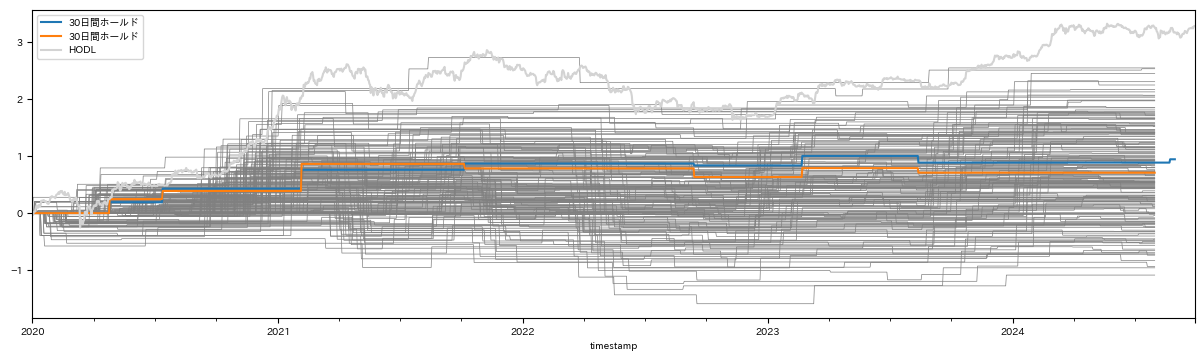

In [50]:
rng = np.random.default_rng()

plt.figure(figsize=(15, 4))
for i in range(200):
    random_indices = rng.choice(tmp.index, size=8, replace=True)
    tmp['bootstrap_buy'] = 0
    tmp.loc[random_indices, 'bootstrap_buy'] = 1
    (tmp['ror_f60'] * tmp['bootstrap_buy']).cumsum().plot(color='gray', lw=0.5)

(tmp['ror_f30'] * tmp['buy_signal']).cumsum().plot(label='30日間ホールド')
(tmp['ror_f60'] * tmp['buy_signal']).cumsum().plot(label='30日間ホールド')
tmp['coinbase_ror'].cumsum().plot(color='lightgray', label='HODL')
plt.legend();

- これを見る限り、ランダムなタイミングでBTCを購入したときとさほどパフォーマンスは変わらない。

- ハッシュリボンは点灯数が少なく、上昇を続けてきた現物のHODLに比べると見劣りする。
- BTCは基本的に上昇を続けてきたため、ランダムなタイミングで購入＆一定期間ホールドする戦略と比べて、さほど優位性を見いだせない。

# まとめ

- 「ハッシュレートによる価格予測は可能か？」
  - 今回の検討では、予測ができるといえる手法を見つけられなかった。

- なんの成果も得られなかったわけではなく、「このやり方では何もわからなかった」ことが分かった。

- 今回は「観測されたハッシュレート」のみを使った表面的な分析であった。
- マイナーの経営状況、オンチェーンでのビットコインの蓄積・放出状況、電気代などのマイニングに関わる環境、経済情勢など、多角的に組み合わせた深みのある分析には至らなかった。
- ハッシュレート関連のよい分析方法について、ご意見お待ちしてます。

- To be continued

## 乖離

## 価格の移動平均乖離と、ハッシュレートの移動平均乖離に関係性があるか？

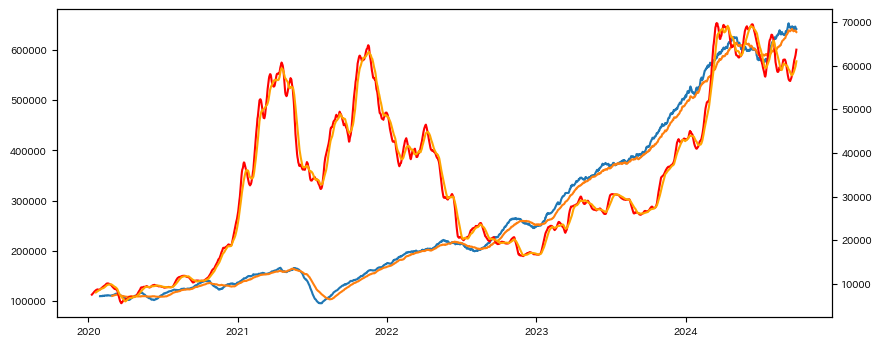

In [261]:
tmp = btcusd['2020-01-01':].copy()
tmp['hash_rate_sma30'] = tmp['hash_rate'].rolling(30).mean()
tmp['hash_rate_sma60'] = tmp['hash_rate'].rolling(60).mean()
tmp['price_sma10'] = tmp['coinbase_open'].rolling(10).mean()
tmp['price_sma20'] = tmp['coinbase_open'].rolling(20).mean()
# tmp['hash_rate_sma30'] = tmp['hash_rate'].pct_change(30)
# tmp['price_sma30'] = tmp['coinbase_open'].pct_change(30)

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax_right = ax.twinx()
ax_right.plot(tmp['price_sma10'], color='red')
ax_right.plot(tmp['price_sma20'], color='orange')
ax.plot(tmp['hash_rate_sma30'])
ax.plot(tmp['hash_rate_sma60']);

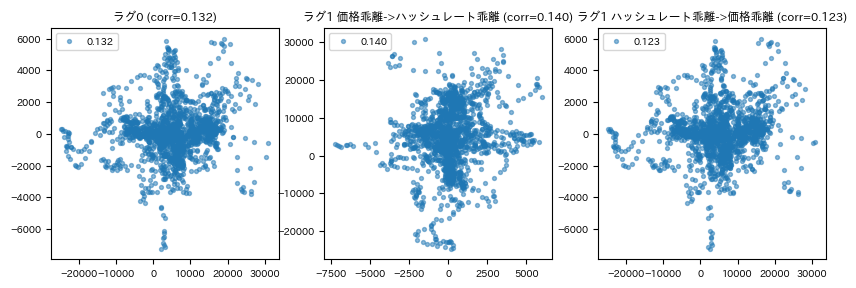

In [262]:
tmp['price_dev'] = tmp['price_sma10'] - tmp['price_sma20']
tmp['hash_rate_dev'] = tmp['hash_rate_sma30'] - tmp['hash_rate_sma60']

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(tmp['hash_rate_dev'], tmp['price_dev'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(tmp['price_dev'].shift(1), tmp['hash_rate_dev'], title='ラグ1 価格乖離->ハッシュレート乖離')
plt.subplot(1, 3, 3)
plot_corr(tmp['hash_rate_dev'].shift(1), tmp['price_dev'], title='ラグ1 ハッシュレート乖離->価格乖離')

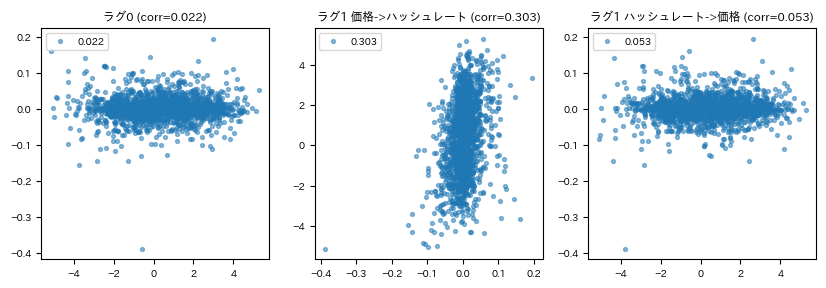

In [258]:
tmp['dev_subtract'] = tmp['price_dev'] - tmp['hash_rate_dev']

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(tmp['dev_subtract'], tmp['coinbase_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(tmp['coinbase_ror'].shift(1), tmp['dev_subtract'], title='ラグ1 価格->ハッシュレート')
plt.subplot(1, 3, 3)
plot_corr(tmp['dev_subtract'].shift(1), tmp['coinbase_ror'], title='ラグ1 ハッシュレート->価格')

## 乖離（divergence）をどう定義するか？

- ハッシュレートは上がっているが、価格は下がっている

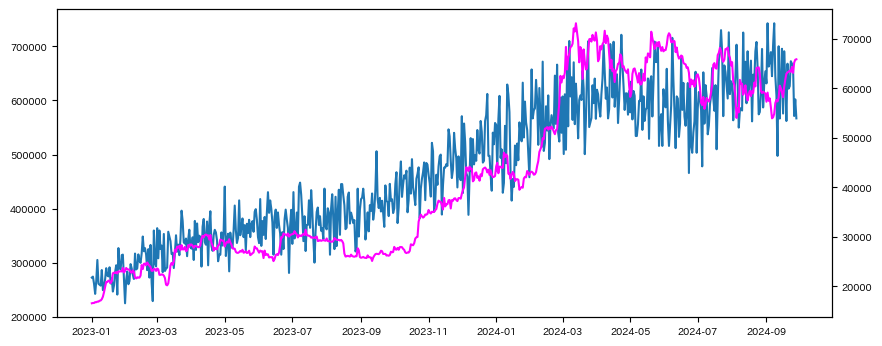

In [62]:
tmp = btcusd['2023-01-01':].copy()
plt.figure(figsize=(10, 4))
ax = plt.gca()
ax_right = ax.twinx()
ax.plot(tmp['hash_rate'])
ax_right.plot(tmp['coinbase_close'], color='magenta');

### 定義1 移動平均線の傾き

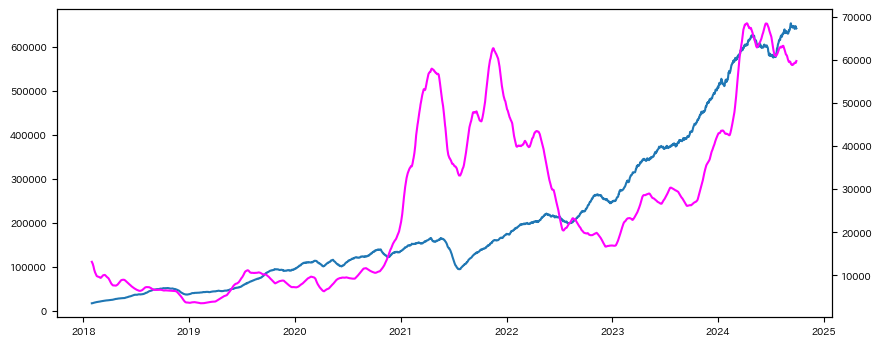

In [68]:
tmp = btcusd['2018-01-01':].copy()
tmp['hash_rate_sma30'] = tmp['hash_rate'].rolling(30).mean()
tmp['price_sma30'] = tmp['coinbase_open'].rolling(30).mean()
# tmp['hash_rate_sma30'] = tmp['hash_rate'].pct_change(30)
# tmp['price_sma30'] = tmp['coinbase_open'].pct_change(30)

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax_right = ax.twinx()
ax.plot(tmp['hash_rate_sma30'])
ax_right.plot(tmp['price_sma30'], color='magenta');

- 移動平均乖離

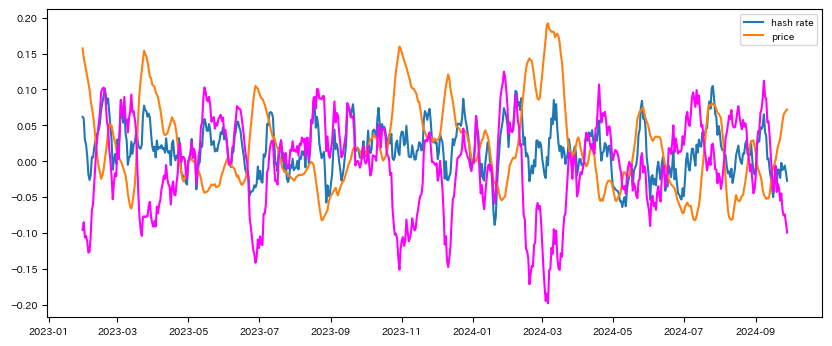

In [85]:
duration1 = 7
duration2 = 30
tmp = btcusd['2023-01-01':].copy()
tmp['hash_rate_dev'] = tmp['hash_rate'].rolling(duration1).mean() / tmp['hash_rate'].rolling(duration2).mean() - 1
tmp['price_dev'] = tmp['coinbase_open'].rolling(duration1).mean() / tmp['coinbase_open'].rolling(duration2).mean() - 1

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(tmp['hash_rate_dev'], label='hash rate')
ax.plot(tmp['price_dev'], label='price');
ax.plot(tmp['hash_rate_dev'] - tmp['price_dev'], color='magenta')
plt.legend();

- ローリング相関

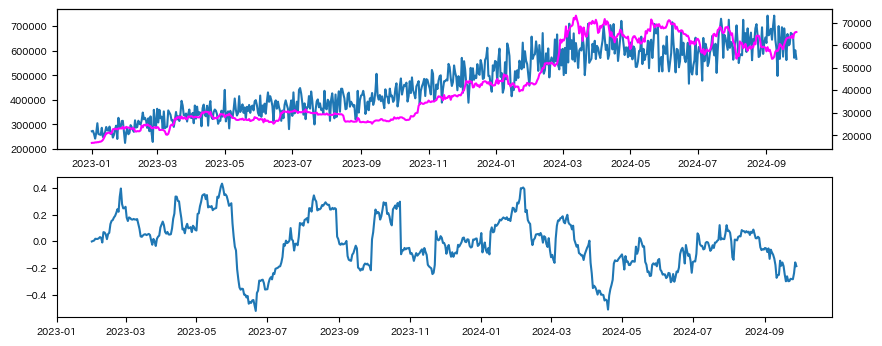

In [76]:
tmp = btcusd['2023-01-01':].copy()
tmp['hash_rate_ror'] = tmp['hash_rate'].pct_change()
tmp['price_ror'] = tmp['coinbase_open'].pct_change()

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
ax = plt.gca()
ax_right = ax.twinx()
ax.plot(tmp['hash_rate'])
ax_right.plot(tmp['coinbase_close'], color='magenta');
plt.subplot(2, 1, 2)
plt.plot(tmp['hash_rate_ror'].rolling(30).corr(tmp['price_ror']));

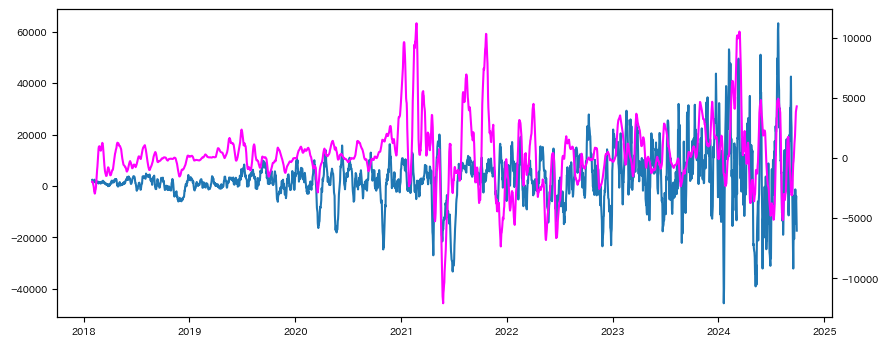

In [71]:
duration1 = 7
duration2 = 30
tmp = btcusd['2018-01-01':].copy()
tmp['hash_rate_sma30'] = tmp['hash_rate'].rolling(duration1).mean() - tmp['hash_rate'].rolling(duration2).mean()
tmp['price_sma30'] = tmp['coinbase_open'].rolling(duration1).mean() - tmp['coinbase_open'].rolling(duration2).mean()

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax_right = ax.twinx()
ax.plot(tmp['hash_rate_sma30'])
ax_right.plot(tmp['price_sma30'], color='magenta');

## ハッシュリボン

- https://note.com/crypto_sakane/n/nffa319f3405e
- "ハッシュリボンは、チャールズ・エドワーズによって開発された、ビットコインの最も強力な買いシグナルの1つとされています。この指標は、暗号通貨のハッシュレートの単純移動平均を使用して、潜在的な市場の底値と採掘者の降伏イベントを識別します。過去の統計では高い精度で価格上昇を予測してきました。"

- https://nextmoney.jp/?p=31591
- Charles Edwards（チャールズ・エドワード）氏によると、ハッシュリボン（60日移動平均線と30日移動平均線）のみで最初はハッシュリボンを提唱していましたが、現時点では正式なハッシュリボンを以下の内容としています。
- 1）ハッシュレートの30日移動平均線と60日移動平均線をプロット
- 2）30日移動平均線が60日移動平均線を上回ったら緑のシグナルが点灯
- 3）ビットコイン価格の10日移動平均線、20日移動平均線をプロット
- 4）2）の状態かつ、BTC価格の10日移動平均線が20日移動平均線を上回ったらハッシュレート移動平均線の部分に青の買いシグナルが点灯

In [86]:
btcusd

,coinbase_open,coinbase_high,coinbase_log,coinbase_close,coinbase_volume,coinbase_ror,hash_rate
timestamp,,,,,,,
2015-08-01 00:00:00+00:00,285.20,285.60,277.26,281.53,3932.449751,-0.012868,402.809138
2015-08-02 00:00:00+00:00,281.53,282.62,277.33,282.62,3361.086689,0.003872,392.414063
2015-08-03 00:00:00+00:00,282.62,285.86,280.27,280.95,4741.729107,-0.005909,408.006675
2015-08-04 00:00:00+00:00,280.95,286.47,280.11,285.51,5580.220530,0.016231,353.432534
2015-08-05 00:00:00+00:00,285.60,286.25,282.01,282.77,5765.487797,-0.009909,345.636228
...,...,...,...,...,...,...,...
2024-09-24 00:00:00+00:00,63338.85,64700.00,62689.15,64272.93,8933.464736,0.014747,667975.711256
2024-09-25 00:00:00+00:00,64272.93,64811.00,62932.80,63130.89,5909.095105,-0.017769,663368.982213
2024-09-26 00:00:00+00:00,63131.13,65865.00,62652.99,65177.21,12789.850355,0.032410,571298.868180


In [93]:
np.min(tmp[['hash_rate_sma30', 'hash_rate_sma60']], axis=1)

timestamp
2023-01-01 00:00:00+00:00              NaN
2023-01-02 00:00:00+00:00              NaN
2023-01-03 00:00:00+00:00              NaN
2023-01-04 00:00:00+00:00              NaN
2023-01-05 00:00:00+00:00              NaN
                                 ...      
2024-09-24 00:00:00+00:00    638637.182661
2024-09-25 00:00:00+00:00    639224.887957
2024-09-26 00:00:00+00:00    638685.952823
2024-09-27 00:00:00+00:00    636620.414449
2024-09-28 00:00:00+00:00    635872.282047
Length: 637, dtype: float64

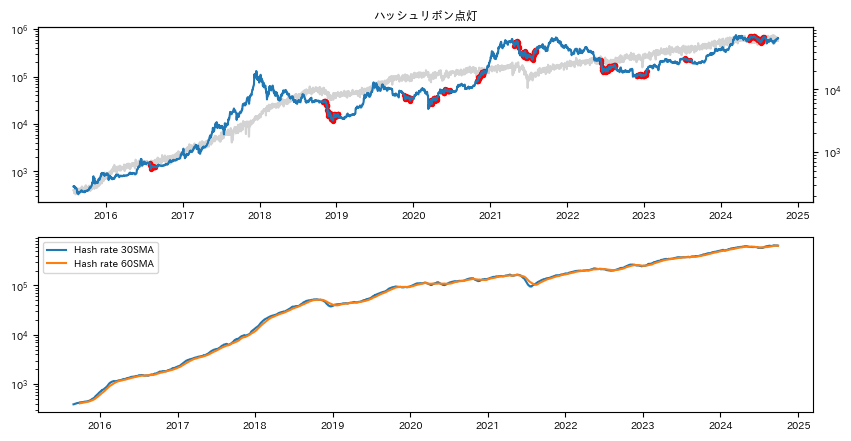

In [139]:
tmp = btcusd['2015-01-01':].sort_index().copy()
tmp['hash_rate_sma30'] = tmp['hash_rate'].rolling(30).mean()
tmp['hash_rate_sma60'] = tmp['hash_rate'].rolling(60).mean()
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title('ハッシュリボン点灯')
ax = plt.gca()
ax.set_yscale('log')
ax.plot(tmp['hash_rate'], color='lightgray')

ax_right = ax.twinx()
ax_right.set_yscale('log')
ax_right.plot(tmp['coinbase_close']);
ax_right.scatter(tmp[tmp['hash_rate_sma30'] < tmp['hash_rate_sma60']].index, tmp[tmp['hash_rate_sma30'] < tmp['hash_rate_sma60']]['coinbase_close'], s=8, color='red')

plt.subplot(2, 1, 2)
ax = plt.gca()
ax.set_yscale('log')
# ax.fill_between(tmp.index, np.min(tmp[['hash_rate_sma30', 'hash_rate_sma60']], axis=1), np.max(tmp[['hash_rate_sma30', 'hash_rate_sma60']], axis=1), color='orange', alpha=0.5);
# ax.fill_between(tmp.index, tmp['hash_rate_sma30'], tmp['hash_rate_sma60'], color='orange', alpha=0.5);
ax.plot(tmp['hash_rate_sma30'], label='Hash rate 30SMA')
ax.plot(tmp['hash_rate_sma60'], label='Hash rate 60SMA')
plt.legend();


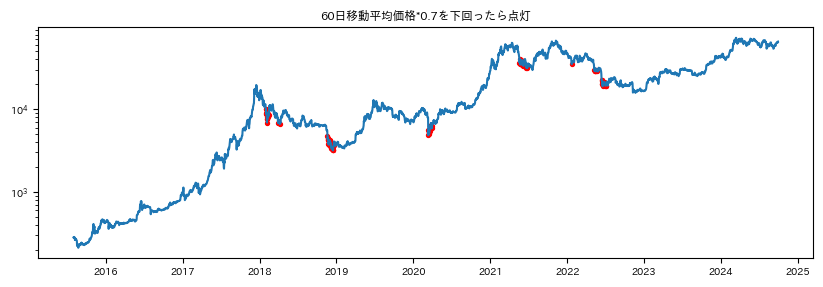

In [147]:
tmp = btcusd['2015-01-01':].sort_index().copy()
tmp['close_mean60'] = tmp['coinbase_close'].rolling(60).mean()
plt.figure(figsize=(10, 3))
plt.title('60日移動平均価格*0.7を下回ったら点灯')
ax = plt.gca()
ax.set_yscale('log')
ax.plot(tmp['coinbase_close']);
ax.scatter(tmp[tmp['coinbase_close'] < tmp['close_mean60']*0.75].index, tmp[tmp['coinbase_close'] < tmp['close_mean60']*0.75]['coinbase_close'], s=8, color='red');